In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib as plot
import seaborn as sns
import warnings
from patsy import dmatrices
%pylab inline
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plot']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
df = pd.read_csv('./data/crime_test.csv')

In [3]:
### probabilidade de um crime de tal natureza (especificar)

###  

In [4]:
df[df['Primary Type']=='NON-CRIMINAL']

,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,...,Longitude,Location,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
7775,2015-06-25 22:45:00,NON-CRIMINAL,FOID - REVOCATION,POLICE FACILITY/VEH PARKING LOT,True,False,1623,16.0,45.0,11,...,-87.766357,"(41.974129858, -87.766357256)",Jefferson Park,2.7,8.6,12.4,13.4,35.5,27751.0,25.0
8703,2014-10-26 12:00:00,NON-CRIMINAL,LOST PASSPORT,CTA TRAIN,False,False,1623,16.0,45.0,11,...,-87.762690,"(41.97008868, -87.762690091)",Jefferson Park,2.7,8.6,12.4,13.4,35.5,27751.0,25.0
11498,2018-04-16 11:15:00,NON-CRIMINAL,NOTIFICATION OF CIVIL NO CONTACT ORDER,POLICE FACILITY/VEH PARKING LOT,True,False,1134,11.0,24.0,27,...,-87.704705,"(41.873699424, -87.704705156)",East Garfield Park,8.2,42.4,19.6,21.3,43.2,12961.0,83.0
53333,2015-11-26 23:30:00,NON-CRIMINAL,LOST PASSPORT,RESTAURANT,False,False,1831,18.0,42.0,8,...,-87.631665,"(41.890013524, -87.631664996)",Near North Side,1.9,12.9,7.0,2.5,22.6,88669.0,1.0
58945,2017-12-16 09:00:00,NON-CRIMINAL,LOST PASSPORT,VEHICLE - OTHER RIDE SERVICE,False,False,1822,18.0,27.0,8,...,-87.643199,"(41.903113054, -87.643199348)",Near North Side,1.9,12.9,7.0,2.5,22.6,88669.0,1.0
69701,2012-05-05 15:00:00,NON-CRIMINAL,LOST PASSPORT,STREET,False,False,1834,18.0,42.0,8,...,-87.624223,"(41.88946287, -87.624222942)",Near North Side,1.9,12.9,7.0,2.5,22.6,88669.0,1.0
70716,2012-07-21 02:00:00,NON-CRIMINAL,LOST PASSPORT,STREET,False,False,1831,18.0,42.0,8,...,-87.628914,"(41.890051565, -87.62891376)",Near North Side,1.9,12.9,7.0,2.5,22.6,88669.0,1.0
73053,2013-11-22 02:00:00,NON-CRIMINAL,LOST PASSPORT,BAR OR TAVERN,False,False,1831,18.0,42.0,8,...,-87.634686,"(41.893179585, -87.634686145)",Near North Side,1.9,12.9,7.0,2.5,22.6,88669.0,1.0
142098,2014-04-10 10:45:00,NON-CRIMINAL,FOID - REVOCATION,PARKING LOT/GARAGE(NON.RESID.),False,False,1034,10.0,25.0,31,...,-87.680530,"(41.844148868, -87.680530044)",Lower West Side,9.6,25.8,15.8,40.7,32.6,16444.0,76.0
175217,2013-10-28 07:15:00,NON-CRIMINAL,FOID - REVOCATION,RESIDENCE,False,False,1221,12.0,1.0,24,...,-87.675390,"(41.892294874, -87.675390277)",West Town,2.3,14.7,6.6,12.9,21.7,43198.0,10.0


In [5]:
#droping x and y coordinates since we have latitude and logitude already
df.index = pd.DatetimeIndex(df.Date)
df['Month'] = df.index.month
df['Day'] = df.index.day
df = df.drop(['Date','Description','Location', 'X Coordinate', 'Y Coordinate', 'COMMUNITY AREA NAME'], axis = 1).drop_duplicates()


In [6]:
df.dtypes

Primary Type                                     object
Location Description                             object
Arrest                                             bool
Domestic                                           bool
Beat                                              int64
District                                        float64
Ward                                            float64
Community Area                                    int64
Year                                              int64
Latitude                                        float64
Longitude                                       float64
PERCENT OF HOUSING CROWDED                      float64
PERCENT HOUSEHOLDS BELOW POVERTY                float64
PERCENT AGED 16+ UNEMPLOYED                     float64
PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA    float64
PERCENT AGED UNDER 18 OR OVER 64                float64
PER CAPITA INCOME                               float64
HARDSHIP INDEX                                  

In [7]:
# transform into categorical 
for col in df.columns:
    if col == 'Longitude':
        
        print('none')
    elif col == 'Latitude':
        print('none')
    else:
        df[col] = pd.Categorical(df[col])

none
none


## Logistics Regression

In [8]:
df.columns

Index(['Primary Type', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'Year', 'Latitude', 'Longitude',
       'PERCENT OF HOUSING CROWDED', 'PERCENT HOUSEHOLDS BELOW POVERTY',
       'PERCENT AGED 16+ UNEMPLOYED',
       'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
       'PERCENT AGED UNDER 18 OR OVER 64', 'PER CAPITA INCOME ',
       'HARDSHIP INDEX', 'Month', 'Day'],
      dtype='object')

In [9]:
df_model = df
df_model.rename(columns={'PERCENT OF HOUSING CROWDED':'percent_housing_crowded'}, inplace=True)
df_model.rename(columns={'PERCENT HOUSEHOLDS BELOW POVERTY':'percent_below_poverty'}, inplace=True)
df_model.rename(columns={'PERCENT AGED 16+ UNEMPLOYED':'percent_above_16_unemployed'}, inplace=True)
df_model.rename(columns={'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA':'percent_above_25_no_diploma'}, inplace=True)
df_model.rename(columns={'PERCENT AGED UNDER 18 OR OVER 64':'percent_old_young'}, inplace=True)
df_model.rename(columns={'PER CAPITA INCOME ':'per_capita_income'}, inplace=True)
df_model.rename(columns={'HARDSHIP INDEX':'hardship_index'}, inplace=True)
df_model.rename(columns={'Location Description':'location_description'}, inplace=True)
df_model.rename(columns={'Community Area':'community_area'}, inplace=True)
df_model.rename(columns={'Primary Type':'primary_type'}, inplace=True)

### Theft values

In [10]:
Y, X = dmatrices('primary_type ~ 0 + Month + Day + location_description + community_area  + percent_below_poverty + Latitude + Longitude + percent_above_16_unemployed  + percent_old_young + per_capita_income + hardship_index', df_model, return_type = 'dataframe')

In [11]:
y_theft = Y['primary_type[THEFT]'].values


In [12]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

In [13]:
X_train, X_test_theft, y_train_theft, y_test_theft = train_test_split(X, y_theft, test_size=0.3, random_state=1)

In [14]:
log_model = LogisticRegression()

In [15]:
log_crime = log_model.fit(X_train, y_train_theft)

In [16]:
log_pred_theft = log_model.predict(X_test_theft)
print('Accuracy:',metrics.accuracy_score(y_test_theft,log_pred_theft))

##checking weight of the variables:

log_weight = Series(log_model.coef_[0],index=X.columns.values)

print('\n Features with the most NEGATIVE weights:\n')
    
for i in log_weight.sort_values()[:5].index:
    print(i)
    
    
print('\n Features with the most POSITIVE weights:\n')
    
for i in log_weight.sort_values()[-5:].index:
    print(i)

Accuracy: 0.7974123664811194

 Features with the most NEGATIVE weights:

location_description[T.ALLEY]
location_description[T.SIDEWALK]
location_description[T.APARTMENT]
location_description[T.RESIDENCE-GARAGE]
location_description[T.RESIDENCE]

 Features with the most POSITIVE weights:

location_description[T.ATHLETIC CLUB]
location_description[T.DRUG STORE]
location_description[T.SMALL RETAIL STORE]
location_description[T.GROCERY FOOD STORE]
location_description[T.DEPARTMENT STORE]


In [17]:
log_weight

Month[1]                 -0.071193
Month[2]                 -0.079467
Month[3]                 -0.101874
Month[4]                 -0.056316
Month[5]                 -0.047535
                            ...   
hardship_index[T.96.0]   -0.038903
hardship_index[T.97.0]   -0.047979
hardship_index[T.98.0]   -0.187157
Latitude                  0.207414
Longitude                 0.110414
Length: 638, dtype: float64

In [18]:
log_weight.sort_values()[:10]

location_description[T.ALLEY]                             -1.311064
location_description[T.SIDEWALK]                          -1.299480
location_description[T.APARTMENT]                         -1.074937
location_description[T.RESIDENCE-GARAGE]                  -1.029533
location_description[T.RESIDENCE]                         -0.837163
location_description[T.CHA PARKING LOT/GROUNDS]           -0.548781
location_description[T.CHA APARTMENT]                     -0.426510
location_description[T.POLICE FACILITY/VEH PARKING LOT]   -0.421717
location_description[T.CTA PLATFORM]                      -0.408572
location_description[T.BANK]                              -0.407079
dtype: float64

## BATTERY

In [19]:
y_battery = Y['primary_type[BATTERY]'].values

In [20]:
X_train_battery, X_test_battery, y_train_battery, y_test_battery = train_test_split(X, y_battery, test_size=0.3, random_state=1)

In [21]:
log_model = LogisticRegression()

In [25]:
log_crime = log_model.fit(X_train_battery, y_train_battery)

In [26]:
log_pred_battery = log_model.predict(X_test_battery)
print('Accuracy:',metrics.accuracy_score(y_test_battery,log_pred_battery))

##checking weight of the variables:

log_weight = Series(log_model.coef_[0],index=X.columns.values)

print('\n Features with the most NEGATIVE weights:\n')
    
for i in log_weight.sort_values()[:5].index:
    print(i)
    
    
print('\n Features with the most POSITIVE weights:\n')
    
for i in log_weight.sort_values()[-5:].index:
    print(i)

Accuracy: 0.819091319392207

 Features with the most NEGATIVE weights:

location_description[T.RESIDENCE-GARAGE]
location_description[T.DEPARTMENT STORE]
location_description[T.SMALL RETAIL STORE]
location_description[T.GROCERY FOOD STORE]
location_description[T.COMMERCIAL / BUSINESS OFFICE]

 Features with the most POSITIVE weights:

location_description[T.RESIDENCE PORCH/HALLWAY]
location_description[T.SCHOOL, PUBLIC, GROUNDS]
location_description[T.BAR OR TAVERN]
location_description[T.APARTMENT]
location_description[T.SCHOOL, PUBLIC, BUILDING]


## CRIMINAL DAMAGE

In [27]:
y_criminal = Y['primary_type[CRIMINAL DAMAGE]'].values

In [28]:
X_train_cd, X_test_cd, y_train_cd, y_test_cd = train_test_split(X, y_criminal, test_size=0.3, random_state=1)

In [29]:
log_model = LogisticRegression()
log_crime = log_model.fit(X_train_cd, y_train_cd)
log_pred_criminal = log_model.predict(X_test_cd)
print('Accuracy:',metrics.accuracy_score(y_test_cd,log_pred_criminal))

##checking weight of the variables:

log_weight = Series(log_model.coef_[0],index=X.columns.values)

print('\n Features with the most NEGATIVE weights:\n')
    
for i in log_weight.sort_values()[:5].index:
    print(i)
    
    
print('\n Features with the most POSITIVE weights:\n')
    
for i in log_weight.sort_values()[-5:].index:
    print(i)

Accuracy: 0.8908229276365277

 Features with the most NEGATIVE weights:

location_description[T.SIDEWALK]
location_description[T.DEPARTMENT STORE]
location_description[T.GROCERY FOOD STORE]
location_description[T.SCHOOL, PUBLIC, BUILDING]
location_description[T.SMALL RETAIL STORE]

 Features with the most POSITIVE weights:

location_description[T.DRIVEWAY - RESIDENTIAL]
location_description[T.RESIDENTIAL YARD (FRONT/BACK)]
location_description[T.STREET]
location_description[T.PARKING LOT/GARAGE(NON.RESID.)]
location_description[T.RESIDENCE-GARAGE]


## Decision Tree

In [ ]:
## Theft

In [30]:
from sklearn import tree
import graphviz
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 4)

In [31]:
result_theft = model.fit(X_train, y_train_theft)

In [32]:
predic_theft_tree = model.predict(X_test_theft)

In [33]:
print('Theft Accuracy:', metrics.accuracy_score(y_test_theft, predic_theft_tree))

Theft Accuracy: 0.7856025274559952


In [34]:
for importance, name in sorted(zip(result_theft.feature_importances_, X_train.columns),reverse=True)[:7]:
    print (name, importance)

location_description[T.DEPARTMENT STORE] 0.3055253065987274
location_description[T.RESIDENCE] 0.25515916380801246
location_description[T.APARTMENT] 0.20627593753658324
location_description[T.SIDEWALK] 0.18782647682155754
percent_above_16_unemployed[T.5.7] 0.022191728691112224
community_area[T.8] 0.01693262585040658
Latitude 0.0034529724394171185


In [35]:
graphviz.Source(tree.export_graphviz(model,
                                     out_file=None,
                                     feature_names=X.columns.values,
                                     filled=True)).render('Theft Tree', format='png')

'Theft Tree.png'

## Battery

In [36]:
result_battery = model.fit(X_train_battery, y_train_battery)

In [37]:
predic_battery_tree = model.predict(X_test_theft)
print('Theft Accuracy:', metrics.accuracy_score(y_test_battery, predic_battery_tree))

Theft Accuracy: 0.8191765708841081


In [38]:
for importance, name in sorted(zip(result_battery.feature_importances_, X_train_battery.columns),reverse=True)[:7]:
    print (name, importance)

location_description[T.APARTMENT] 0.4501283064463056
location_description[T.SIDEWALK] 0.22579193532465439
location_description[T.RESIDENCE] 0.162152397011722
location_description[T.SCHOOL, PUBLIC, BUILDING] 0.10207059628187401
Latitude 0.04088365802337725
Longitude 0.01497407369426012
community_area[T.41] 0.0022222230939923557


In [39]:
graphviz.Source(tree.export_graphviz(model,
                                     out_file=None,
                                     feature_names=X.columns.values,
                                     filled=True)).render('Battery Tree', format='png')

'Battery Tree.png'

## Criminal Damage

In [40]:
result_cd = model.fit(X_train_cd, y_train_cd)
predic_cd_tree = model.predict(X_test_cd)
print('Theft Accuracy:', metrics.accuracy_score(y_test_cd, predic_cd_tree))

Theft Accuracy: 0.8908229276365277


In [41]:
for importance, name in sorted(zip(result_battery.feature_importances_, X_train_battery.columns),reverse=True)[:7]:
    print (name, importance)

location_description[T.SIDEWALK] 0.575231357715744
location_description[T.STREET] 0.18608234238801616
location_description[T.RESIDENCE-GARAGE] 0.12716715808237758
location_description[T.DEPARTMENT STORE] 0.06533058003869778
Latitude 0.03502140276000497
Longitude 0.008833492566447275
community_area[T.63] 0.0016486510624954941


In [42]:
graphviz.Source(tree.export_graphviz(model,
                                     out_file=None,
                                     feature_names=X.columns.values,
                                     filled=True)).render('CD Tree', format='png')

'CD Tree.png'

## Testing new Variables

In [43]:
 df_test = df_model[['primary_type','location_description','community_area','percent_housing_crowded','percent_below_poverty','percent_above_16_unemployed','percent_above_25_no_diploma','percent_old_young','per_capita_income','hardship_index']]

In [44]:
df_test = df_test[(df_test['primary_type']=='THEFT')|(df_test['primary_type']=='BATTERY')|(df_test['primary_type']=='CRIMINAL DAMAGE')|(df_test['primary_type']=='NARCOTICS')]

In [45]:
df_test.reset_index(drop=True,inplace=True)

In [46]:
from mlxtend.plotting import plot_decision_regions
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier

In [47]:
my_dict = {'NARCOTICS':1, 'THEFT':2, 'BATTERY':3, 'CRIMINAL DAMAGE':4}

In [48]:
df_test['primary_type'] = df_test['primary_type'].map(my_dict)

In [49]:
Y = df_test['primary_type']

In [50]:
X = df_test.drop(['primary_type','location_description'],axis=1)

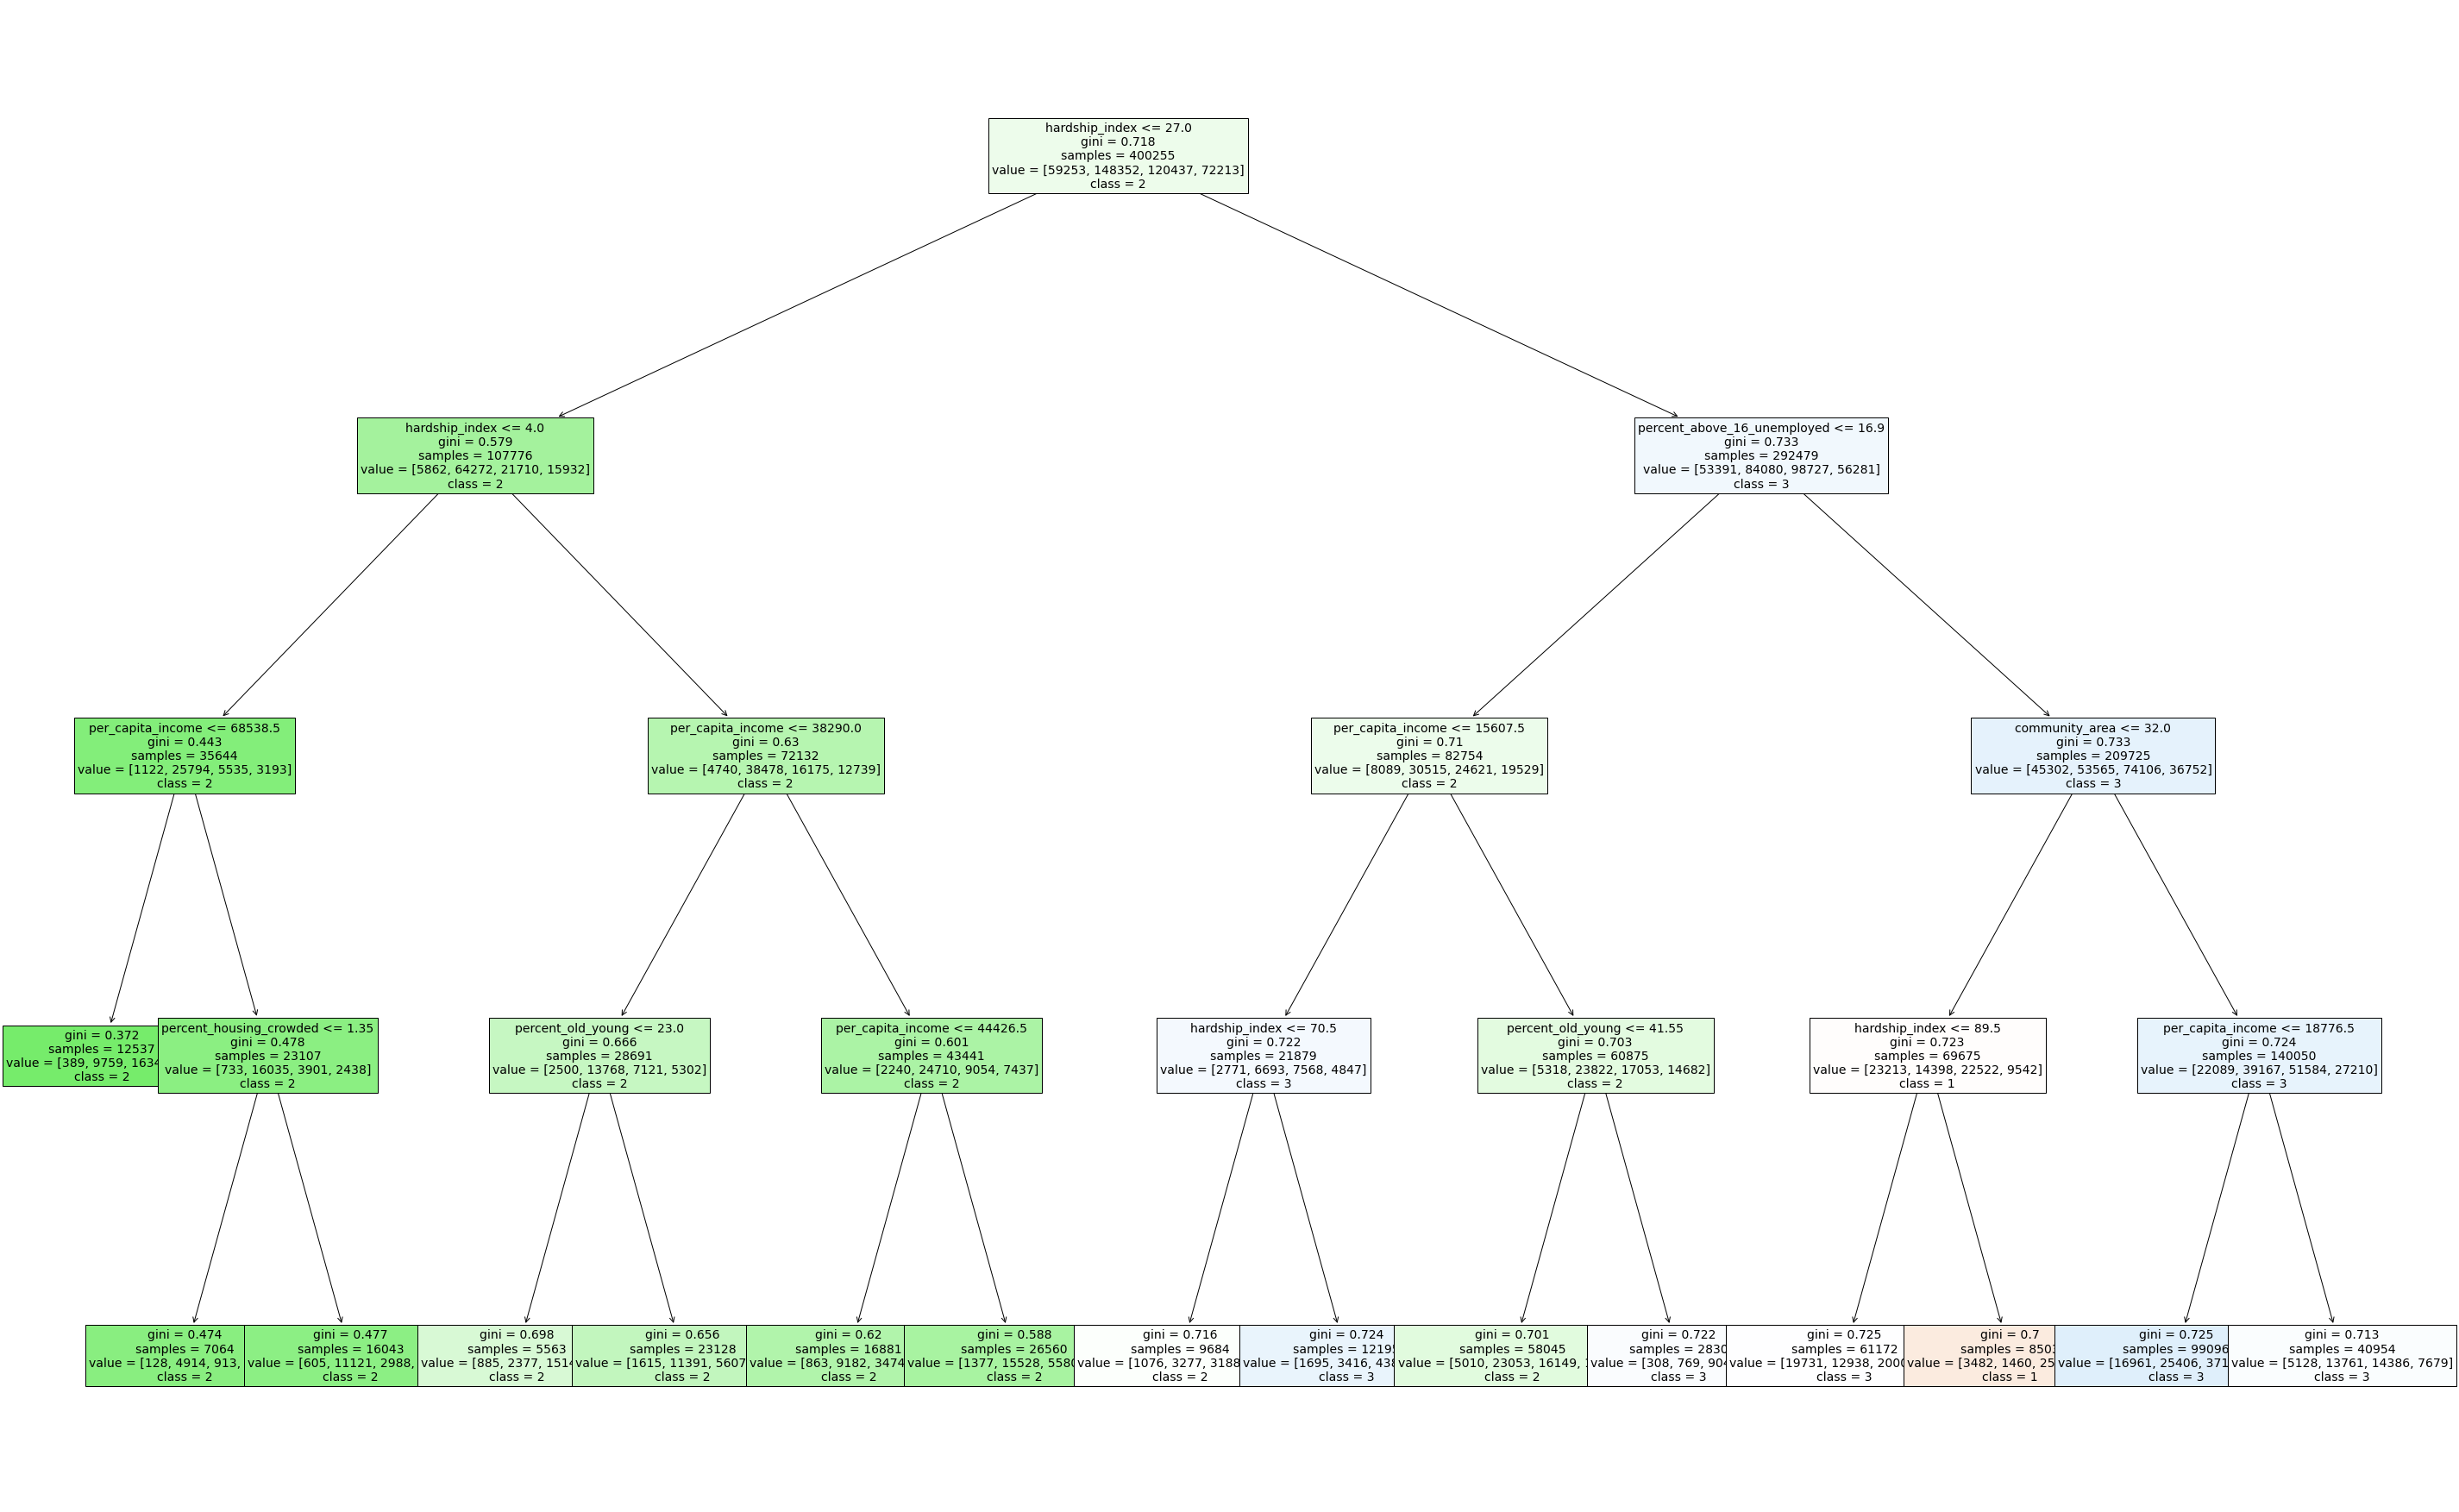

In [51]:
fig, ax = plt.subplots(figsize=(50,32))

tree = DecisionTreeClassifier(max_depth=4)
tree.fit(X, Y)
# plot_decision_regions(np.array(X), np.array(Y), tree, ax=ax[0])
plot_tree(tree,filled=True,feature_names=X.columns,class_names=['1','2','3','4'],fontsize=14 );


In [52]:
for importance, name in sorted(zip(tree.feature_importances_, X.columns),reverse=True)[:10]:
    print (name, importance)

hardship_index 0.7052099258939764
percent_above_16_unemployed 0.12017962711686767
community_area 0.1160615104975349
per_capita_income 0.047999636227596454
percent_old_young 0.00785099911493543
percent_housing_crowded 0.002698301149089002
percent_below_poverty 0.0
percent_above_25_no_diploma 0.0
